## Project: Build a Traffic Sign Recognition Classifier

There is a [Writeup](./writeup.md) that can be used to guide the writing process.

### Importing libraries
Import the library used in this project

In [1]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import cv2
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

---
## Step 0: Load The Data
The following provides data is not registered in the repository

In [2]:
# Use training data provided by Udacity
training_file = 'data/traffic-signs-data/train.p'
validation_file= 'data/traffic-signs-data/valid.p'
testing_file = 'data/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of validation examples
n_validation = len(y_valid)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = x_train.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

In [4]:
# Get Sign Name
with open('./signnames.csv', 'r') as f:
    sign_name = dict(line.strip().split(',') for line in f.readlines()[1:])

# Classify ID by classes
train_id_by_classes = [[idx for idx, sign_id in enumerate(y_train) if sign_id == i] for i in range(n_classes)]
valid_id_by_classes = [[idx for idx, sign_id in enumerate(y_valid) if sign_id == i] for i in range(n_classes)]
test_id_by_classes = [[idx for idx, sign_id in enumerate(y_test) if sign_id == i] for i in range(n_classes)]


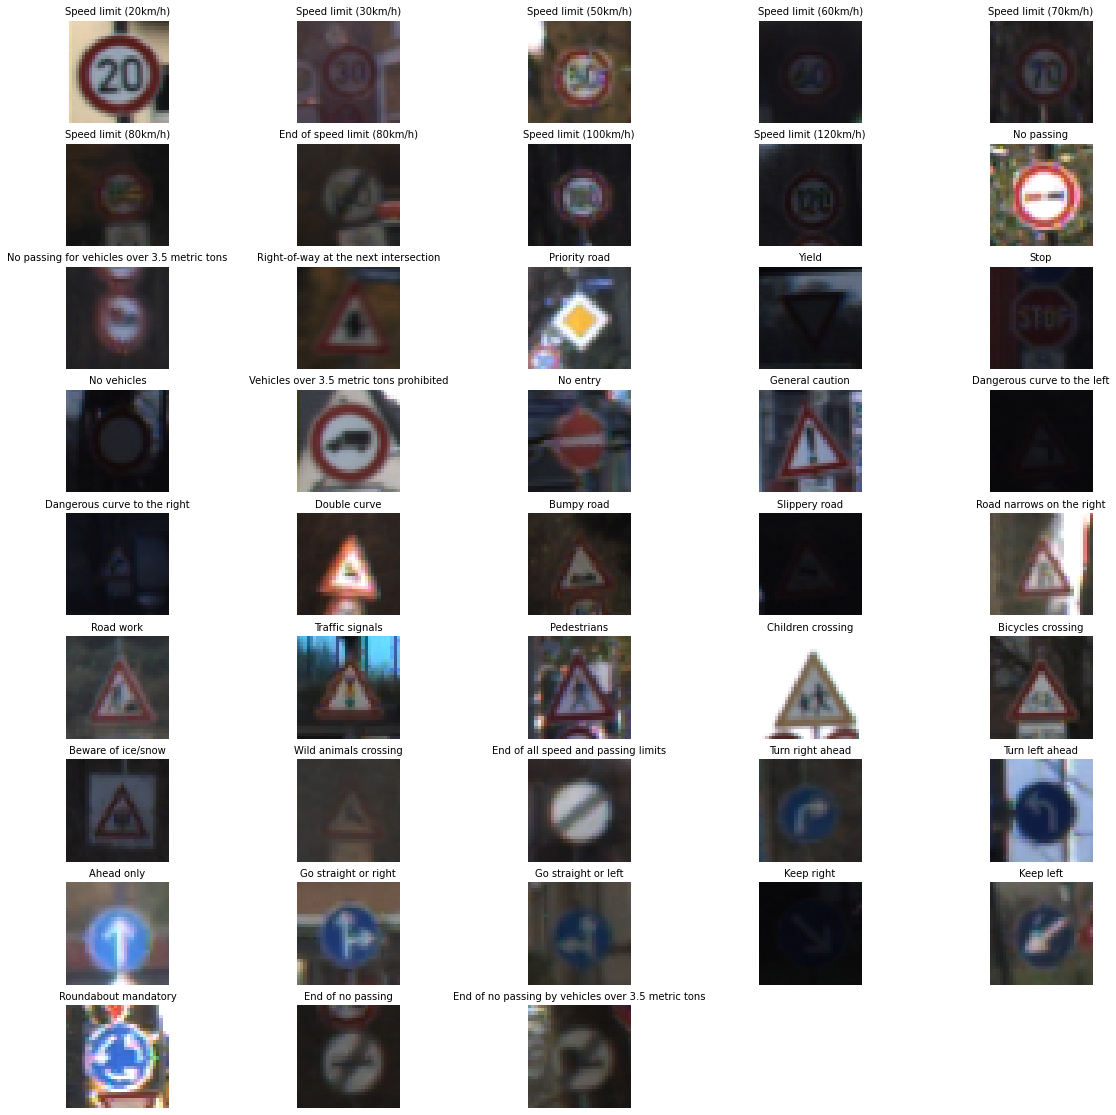

In [5]:
#draw the first image of each class
plt.figure(figsize=(20, 20))
for i in range(n_classes):
    plt.subplot(9, 5, i+1)
    plt.imshow(x_train[train_id_by_classes[i][0]]) 
    plt.title(sign_name[str(i)], fontsize=10)
    plt.axis('off')
plt.show()

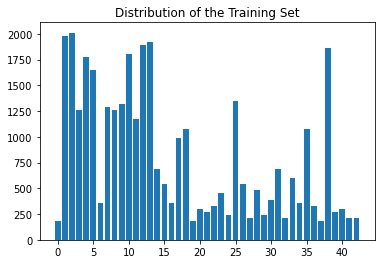

Min number of images per class = 180
Max number of images per class = 2010


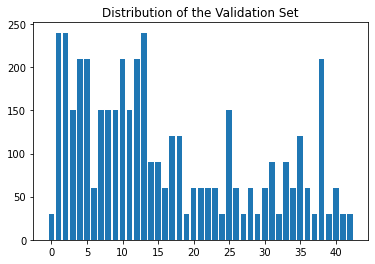

Min number of images per class = 30
Max number of images per class = 240


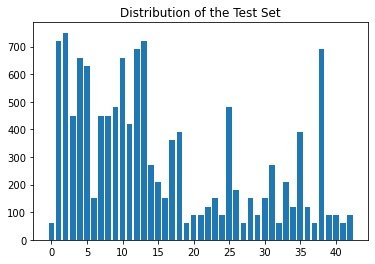

Min number of images per class = 60
Max number of images per class = 750


In [6]:
# Distribution of the Training Set
plt.bar(range(n_classes), [len(s) for s in train_id_by_classes])
plt.xticks(range(0, n_classes, 5))
plt.title('Distribution of the Training Set')
plt.show()
print("Min number of images per class =", min([len(s) for s in train_id_by_classes]))
print("Max number of images per class =", max([len(s) for s in train_id_by_classes]))

# Distribution of the Validation Set
plt.bar(range(n_classes), [len(s) for s in valid_id_by_classes])
plt.xticks(range(0, n_classes, 5))
plt.title('Distribution of the Validation Set')
plt.show()
print("Min number of images per class =", min([len(s) for s in valid_id_by_classes]))
print("Max number of images per class =", max([len(s) for s in valid_id_by_classes]))

# Distribution of the Test Set
plt.bar(range(n_classes), [len(s) for s in test_id_by_classes])
plt.xticks(range(0, n_classes, 5))
plt.title('Distribution of the Test Set')
plt.show()
print("Min number of images per class =", min([len(s) for s in test_id_by_classes]))
print("Max number of images per class =", max([len(s) for s in test_id_by_classes]))


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

print('x_train.shape = ',x_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('x_test.shape = ',x_test.shape)

y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)
y_test = to_categorical(y_test, 43)

print('y_train.shape = ',y_train.shape)
print('y_valid.shape = ',y_valid.shape)
print('y_test.shape = ',y_test.shape)

def reshape_raw_images(imgs):
    def gray(src):
        dst = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
        dst = (dst - 128.)/ 128.
        return dst.reshape(32,32,1)
    norms = [gray(img) for img in imgs]
    return np.array(norms)
    
features_train = reshape_raw_images(x_train)
labels_train   = y_train

features_valid = reshape_raw_images(x_valid)
labels_valid   = y_valid

features_test  = reshape_raw_images(x_test)
labels_test    = y_test

print('labels_train.shape = ',labels_train.shape)
print('labels_valid.shape = ',labels_valid.shape)
print('labels_test.shape = ',labels_test.shape)

x_train.shape =  (34799, 32, 32, 3)
x_valid.shape =  (4410, 32, 32, 3)
x_test.shape =  (12630, 32, 32, 3)
y_train.shape =  (34799, 43)
y_valid.shape =  (4410, 43)
y_test.shape =  (12630, 43)
labels_train.shape =  (34799, 43)
labels_valid.shape =  (4410, 43)
labels_test.shape =  (12630, 43)


### Model Architecture

In [8]:
# Create model
model = Sequential()

# Conv->Conv->Pool->Dropout
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32,32,1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv->Conv->Pool->Dropout
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten->Dense->Dropout->Dense
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(43, activation='softmax'))

model.compile(loss='categorical_crossentropy',  optimizer=Adam(lr=0.001), metrics=['acc'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [10]:
history = model.fit(features_train, labels_train, batch_size=512, epochs=20, shuffle=1, validation_data=(features_valid,labels_valid))

Epoch 1/20
68/68 [==============================] - 38s 565ms/step - loss: 2.3588 - acc: 0.3994 - val_loss: 2.8903 - val_acc: 0.4930
Epoch 2/20
68/68 [==============================] - 38s 554ms/step - loss: 0.5594 - acc: 0.8638 - val_loss: 2.0164 - val_acc: 0.8306
Epoch 3/20
68/68 [==============================] - 38s 554ms/step - loss: 0.1964 - acc: 0.9604 - val_loss: 1.1838 - val_acc: 0.9381
Epoch 4/20
68/68 [==============================] - 38s 552ms/step - loss: 0.1004 - acc: 0.9813 - val_loss: 0.5751 - val_acc: 0.9596
Epoch 5/20
68/68 [==============================] - 38s 554ms/step - loss: 0.0649 - acc: 0.9875 - val_loss: 0.2427 - val_acc: 0.9696
Epoch 6/20
68/68 [==============================] - 38s 557ms/step - loss: 0.0435 - acc: 0.9919 - val_loss: 0.1505 - val_acc: 0.9692
Epoch 7/20
68/68 [==============================] - 38s 554ms/step - loss: 0.0312 - acc: 0.9945 - val_loss: 0.0995 - val_acc: 0.9732
Epoch 8/20
68/68 [==============================] - 38s 554ms/step - 

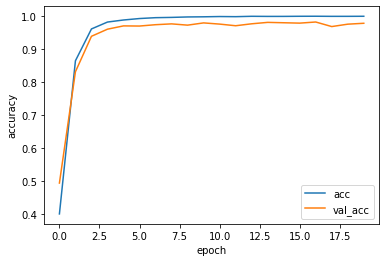

In [11]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

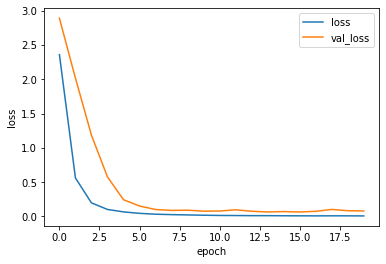

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [13]:
test_loss, test_acc = model.evaluate(features_test, labels_test)
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc))

395/395 [==============================] - 3s 9ms/step - loss: 0.0897 - acc: 0.9740
loss: 0.090
acc: 0.974


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

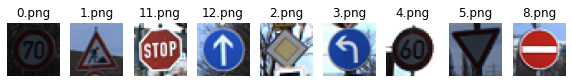

In [14]:
# Load test iamges
new_images = glob.glob('./data/german-traffic-sign-dataset/*.png')
new_datas = []
plt.subplots(1, len(new_images), figsize=(10,20))
for idx, fname in enumerate(new_images):
    img = cv2.imread(fname)
    new_datas.append(img.astype('float32'))
    plt.subplot(1, len(new_images), (idx+1))
    plt.title(os.path.basename(fname))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))    
plt.show()

gray_images = reshape_raw_images(new_datas)

### Predict the Sign Type for Each Image

In [15]:
y_test = [4, 25, 14, 35, 12, 34, 3, 13, 17]
labels_test = to_categorical(y_test, 43)

In [16]:
top_probs = []
top_idxs = []
for gray_image in gray_images:
    image_batch = tf.expand_dims(gray_image, 0)
    predictions = model(image_batch)
    probs = tf.nn.softmax(predictions, axis=-1)
    top_prob, top_idx = tf.math.top_k(input=probs, k=5)
    top_probs.append(top_prob.numpy()[0])
    top_idxs.append(top_idx.numpy()[0])

### Analyze Performance

In [17]:
test_loss, test_acc = model.evaluate(gray_images, labels_test)
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc))

1/1 [==============================] - 0s 1ms/step - loss: 1.9667e-04 - acc: 1.0000
loss: 0.000
acc: 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

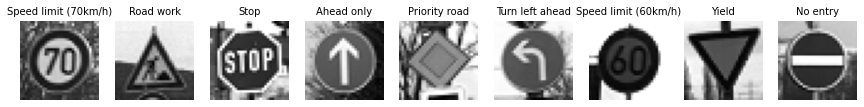

InputSignName : Speed limit (70km/h)
     4 : Speed limit (70km/h)                               : 6.08%
     0 : Speed limit (20km/h)                               : 2.24%
    33 : Turn right ahead                                   : 2.24%
    39 : Keep left                                          : 2.24%
     8 : Speed limit (120km/h)                              : 2.24%
InputSignName : Road work
    25 : Road work                                          : 6.08%
     3 : Speed limit (60km/h)                               : 2.24%
    20 : Dangerous curve to the right                       : 2.24%
    30 : Beware of ice/snow                                 : 2.24%
     0 : Speed limit (20km/h)                               : 2.24%
InputSignName : Stop
    14 : Stop                                               : 6.08%
    33 : Turn right ahead                                   : 2.24%
    39 : Keep left                                          : 2.24%
     6 : End of speed limit (80k

In [18]:
plt.subplots(1, len(gray_images), figsize=(15,20))
for idx, gray_image in enumerate(gray_images):
    plt.subplot(1, len(gray_images), idx+1)
    plt.title(sign_name[str(y_test[idx])], fontsize=10)
    plt.axis('off')
    plt.imshow(gray_image, cmap='gray')
plt.show()
print('='*70)
for i in range(len(gray_images)):
    print("InputSignName : {}".format(sign_name[str(y_test[i])]))
    for j in range(len(top_idxs[i])):
        print("    {:2} : {:50} : {:.2f}%".format( top_idxs[i][j], sign_name[str(top_idxs[i][j])], top_probs[i][j]*100))
    print('='*70)
